In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.95MB/s]


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU()
        )

        self.mu_layer = nn.Linear(400, latent_dim)
        self.logvar_layer = nn.Linear(400, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


In [4]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x.view(-1, 28 * 28), reduction='sum'
    )

    kl_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return recon_loss + kl_loss


In [5]:
model = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
train_losses = []
val_losses = []


In [6]:
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for x, _ in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            val_loss += vae_loss(recon_x, x, mu, logvar).item()

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch [1/20] | Train Loss: 163.1777 | Val Loss: 125.5073
Epoch [2/20] | Train Loss: 120.5202 | Val Loss: 115.0558
Epoch [3/20] | Train Loss: 114.1987 | Val Loss: 111.4023
Epoch [4/20] | Train Loss: 111.3109 | Val Loss: 109.4652
Epoch [5/20] | Train Loss: 109.5649 | Val Loss: 108.1855
Epoch [6/20] | Train Loss: 108.4026 | Val Loss: 107.2489
Epoch [7/20] | Train Loss: 107.6047 | Val Loss: 106.6464
Epoch [8/20] | Train Loss: 106.9615 | Val Loss: 106.3842
Epoch [9/20] | Train Loss: 106.4630 | Val Loss: 105.8365
Epoch [10/20] | Train Loss: 106.0397 | Val Loss: 105.4814
Epoch [11/20] | Train Loss: 105.7122 | Val Loss: 105.2949
Epoch [12/20] | Train Loss: 105.3865 | Val Loss: 104.9163
Epoch [13/20] | Train Loss: 105.1468 | Val Loss: 104.8905
Epoch [14/20] | Train Loss: 104.9093 | Val Loss: 104.4723
Epoch [15/20] | Train Loss: 104.6969 | Val Loss: 104.3547
Epoch [16/20] | Train Loss: 104.4943 | Val Loss: 104.2924
Epoch [17/20] | Train Loss: 104.3592 | Val Loss: 104.1539
Epoch [18/20] | Train L

In [7]:
model.eval()
with torch.no_grad():
    z = torch.randn(16, 20).to(device)
    samples = model.decoder(z)



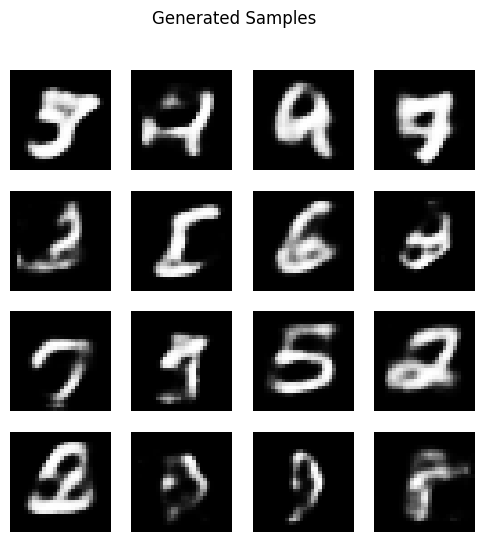

In [8]:
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i].view(28, 28).cpu(), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Samples")
plt.show()

In [9]:
model.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)
    recon_x, _, _ = model(x)


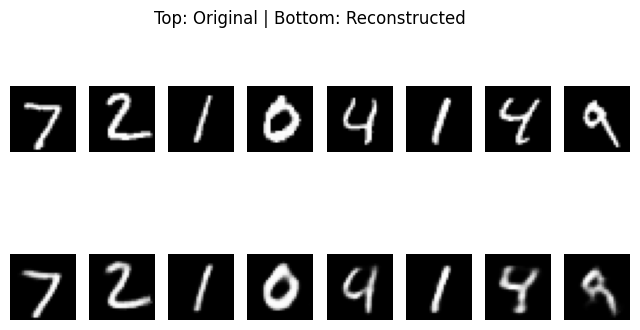

In [10]:
plt.figure(figsize=(8, 4))
for i in range(8):
    # Original
    plt.subplot(2, 8, i + 1)
    plt.imshow(x[i].view(28, 28).cpu(), cmap="gray")
    plt.axis("off")

    # Reconstructed
    plt.subplot(2, 8, i + 9)
    plt.imshow(recon_x[i].view(28, 28).cpu(), cmap="gray")
    plt.axis("off")

plt.suptitle("Top: Original | Bottom: Reconstructed")
plt.show()
